In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import datetime as dt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
import statistics
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.neural_network import MLPRegressor

#importing the MAC season 4 dataset 
flag=pd.read_csv("/Users/ishitadebnath/Desktop/Genomics/MAC season 4/processed-2/days_gdd_to_flag_leaf_emergence_season_4.csv" , delimiter=",")


In [2]:
#importing the distance matrix for cultivar information
dist=pd.read_csv("/Users/ishitadebnath/Desktop/Genomics/allcultivars.csv")

s=dist['Column1'].tolist()
dist.columns = dist.columns[:0].tolist() + s
dist=dist.drop([0])
dist=dist.rename(columns={np.nan: "genotype"})
dist=dist.fillna(0)

flag=flag.sort_values("genotype",axis=0, ascending=True)
flag=pd.merge(flag, dist, on="genotype", how='inner')
print(flag[["genotype", "PI144134"]])



     genotype  PI144134
0    PI144134  0.000000
1    PI144134  0.000000
2    PI145626  0.155730
3    PI145626  0.155730
4    PI145633  0.174188
..        ...       ...
139  PI656035  0.166933
140  PI656065  0.177510
141  PI656065  0.177510
142   PI92270  0.187266
143   PI92270  0.187266

[144 rows x 2 columns]


In [3]:
#importing the soil parameters to add as features
sand=pd.read_csv("/Users/ishitadebnath/Desktop/Genomics/mac_soil_data/sand_data_2020-05-05T120719.csv")
new = sand["plot"].str.split(" ", n = -1, expand = True) 

sand["range"]=new[1]
sand["column"]=new[3]
sand=sand.drop(columns=['plot'])
clay=pd.read_csv("/Users/ishitadebnath/Desktop/Genomics/mac_soil_data/clay_data_2020-05-05T122338.csv")
new =clay["plot"].str.split(" ", n = -1, expand = True) 

clay["range"]=new[1]
clay["column"]=new[3]
clay=clay.drop(columns=['plot'])
soil=pd.read_csv("/Users/ishitadebnath/Desktop/Genomics/mac_soil_data/soil_class_data_2020-05-05T141157.csv")
new = soil["plot"].str.split(" ", n = -1, expand = True) 
soil["range"]=new[1]
soil["column"]=new[3]
soil=soil.drop(columns=['plot'])
soil=pd.merge(soil, clay, on=["range", "column"], how='left')
soil=pd.merge(soil, sand, on=["range", "column"], how='left')

print(soil)

soil.range= soil['range'].astype(int)
soil.column= soil['column'].astype(int)
flag.range= flag['range'].astype(int)
flag.column= flag['column'].astype(int)

flag=pd.merge(flag, soil, on=["range", "column"], how='left')

     band_1_soil_class_avg range column  band_1_clay_avg  band_1_sand_avg
0                      7.0    54     13             32.6             51.4
1                      7.0    45      4             29.8             54.0
2                      7.0    37     15             30.2             52.8
3                      7.0    44      4             29.7             53.7
4                      7.0    35     11             31.9             52.2
..                     ...   ...    ...              ...              ...
859                    7.0    43      6             29.3             54.3
860                    7.0    48      7             31.2             52.8
861                    7.0     6     14             34.0             50.3
862                    7.0    49      7             31.6             52.4
863                    7.0    13     13             33.0             51.3

[864 rows x 5 columns]


In [4]:
#creating environmental features from weather data for KSU. Calculating the mean, minimum and maximum for the variables.
fl_date=flag["date_of_flag_leaf_emergence"]

fl_delta = flag["days_to_flag_leaf_emergence"]

env=pd.read_csv("/Users/ishitadebnath/Desktop/Genomics/MAC season 4/processed-2/mac_season_4_daily_weather_2020-07-01T144735.csv")
env['date']=pd.to_datetime(env.date)
#for calculating mean
tmax = []
tmin = []
tmean =[]
rh1 = []
rh2 = []
rh3 = []
p1=[]
wsm = []
wvm = []
wvd = []
wds = []
mws = []
gdd = []
cp = []

for j in range(len(fl_date)):
    ss = (env['date']>= '2017-04-20') & (env['date'] <= fl_date[j])
    df_1 = env[ss]
    tmax.append(df_1['air_temp_max'].mean())
    tmin.append(df_1['air_temp_min'].mean())
    tmean.append(df_1['air_temp_mean'].mean())
    rh1.append(df_1['rh_max'].mean())
    rh2.append(df_1['rh_min'].mean())
    rh3.append(df_1['rh_mean'].mean())
    p1.append(df_1['precip_total'].mean())
    wsm.append(df_1['wind_speed_mean'].mean())
    wvm.append(df_1['wind_vector_magnitude'].mean())
    wvd.append(df_1['wind_vector_direction'].mean())
    wds.append(df_1['wind_direction_std'].mean())
    mws.append(df_1['max_wind_speed'].mean())
    gdd.append(df_1['gdd'].mean())
    cp.append(df_1['cum_precip'].mean())

flag.insert(1,'temp_max_mean',tmax)
flag.insert(2,'temp_min_mean',tmin)
flag.insert(3,'temp_mean_mean',tmean)
flag.insert(4,'rhmax_mean',rh1)
flag.insert(5,'rhmin_mean',rh2)
flag.insert(6,'rhmean_mean',rh3)
flag.insert(7,'totalpre_mean',p1)
flag.insert(8,'wspeedmean_mean',wsm)
flag.insert(9, 'wind vector_mag_mean',wvm)
flag.insert(10,'wvdir_mean',wvd)
flag.insert(11,'windstd_mean',wds)
flag.insert(12,'maxwind_mean',mws)
flag.insert(13,'gddmean',gdd)
flag.insert(14,'cumprecip_mean',cp)

#for max
t1= []
t2= []
t3 = []
r1 = []
r2 = []
r3 = []
p11=[]
wsm1 = []
wvm1 = []
wvd1 = []
wds1 = []
mws1 = []
gdd1 = []
cp1 = []

for k in range(len(fl_date)):
    ss = (env['date']>= '2017-04-20') & (env['date'] <= fl_date[k])
    df_1 = env[ss]
    t1.append(df_1['air_temp_max'].max())
    t2.append(df_1['air_temp_min'].max())
    t3.append(df_1['air_temp_mean'].max())
    r1.append(df_1['rh_max'].max())
    r2.append(df_1['rh_min'].max())
    r3.append(df_1['rh_mean'].max())
    p11.append(df_1['precip_total'].max())
    wsm1.append(df_1['wind_speed_mean'].max())
    wvm1.append(df_1['wind_vector_magnitude'].max())
    wvd1.append(df_1['wind_vector_direction'].max())
    wds1.append(df_1['wind_direction_std'].max())
    mws1.append(df_1['max_wind_speed'].max())
    gdd1.append(df_1['gdd'].max())
    cp1.append(df_1['cum_precip'].max())

flag.insert(1,'temp_max_max',t1)
flag.insert(2,'temp_min_max',t2)
flag.insert(3,'temp_mean_max',t3)
flag.insert(4,'rh_max_max',r1)
flag.insert(5,'rh_min_max',r2)
flag.insert(6,'rh_mean_max',r3)
flag.insert(7,'totalpre_max',p11)
flag.insert(8,'wspeedmean_max',wsm1)
flag.insert(9, 'wind vector_mag_max',wvm1)
flag.insert(10,'wvdir_max',wvd1)
flag.insert(11,'windstd_max',wds1)
flag.insert(12,'maxwind_max',mws1)
flag.insert(13,'gddmax',gdd1)
flag.insert(14,'cumprecip_max',cp1)

#for min
t12= []
t22= []
t32 = []
r12 = []
r22 = []
r32 = []
p12=[]
wsm2 = []
wvm2 = []
wvd2 = []
wds2 = []
mws2 = []
gdd2 = []
cp2 = []

for l in range(len(fl_date)):
    ss = (env['date']>= '2017-04-20') & (env['date'] <= fl_date[l])
    df_1 = env[ss]
    t12.append(df_1['air_temp_max'].min())
    t22.append(df_1['air_temp_min'].min())
    t32.append(df_1['air_temp_mean'].min())
    r12.append(df_1['rh_max'].min())
    r22.append(df_1['rh_min'].min())
    r32.append(df_1['rh_mean'].min())
    p12.append(df_1['precip_total'].min())
    wsm2.append(df_1['wind_speed_mean'].min())
    wvm2.append(df_1['wind_vector_magnitude'].min())
    wvd2.append(df_1['wind_vector_direction'].min())
    wds2.append(df_1['wind_direction_std'].min())
    mws2.append(df_1['max_wind_speed'].min())
    gdd2.append(df_1['gdd'].min())
    cp2.append(df_1['cum_precip'].min())

flag.insert(1,'temp_max_min',t12)
flag.insert(2,'temp_min_min',t22)
flag.insert(3,'temp_mean_min',t32)
flag.insert(4,'rh_max_min',r12)
flag.insert(5,'rh_min_min',r22)
flag.insert(6,'rh_mean_min',r32)
flag.insert(7,'totalpre_min',p12)
flag.insert(8,'wspeedmean_min',wsm2)
flag.insert(9, 'wind vector_mag_min',wvm2)
flag.insert(10,'wvdir_min',wvd2)
flag.insert(11,'windstd_min',wds2)
flag.insert(12,'maxwind_min',mws2)
flag.insert(13,'gddmin',gdd2)
flag.insert(14,'cumprecip_min',cp2)

#creating input vector

In [5]:
#Creating feature vector(X) and output variable(y)
tmp=flag.drop(['plot', 'scientificname','treatment', 'blocking_height', 'method','date_of_flag_leaf_emergence', 'days_to_flag_leaf_emergence',
       'gdd_to_flag_leaf_emergence', 'method_type','genotype'], axis=1)
print(tmp.shape)
print(flag.shape)

X=tmp.to_numpy()
print(X.shape)

minmax = preprocessing.MinMaxScaler()
X=minmax.fit_transform(X)

y = flag[['days_to_flag_leaf_emergence']]
y = np.asarray(y).flatten()

print(X.shape)

(144, 411)
(144, 421)
(144, 411)
(144, 411)


In [6]:
#Implementation of different algorithms

# 5 fold cross-validation for Random Forest
groups=flag.genotype
ns=5
cv = GroupKFold(n_splits=ns)
error=0
R2=0
e=[]
for train_index, test_index in cv.split(X, y,groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print('TRAIN :',X_train.shape, 'TEST :', X_test.shape)
    crf=RandomForestRegressor(n_estimators=411).fit(X_train, y_train)

    pred=crf.predict(X_test)
    error=error+math.sqrt(np.sum((pred-y_test)**2)/y_test.shape[0])
    R2=R2+r2_score(y_test, pred)
    e.append(math.sqrt(mean_squared_error(y_test, pred)))
    error=error+math.sqrt(mean_squared_error(y_test, pred))

std= (statistics.stdev(e))
print('R^2 for 5-fold CV RF:', R2/ns)
print('Root Mean square error for 5-fold CV RF',error/ns,'+-', std)

# 5 fold cross-validation for Stochastic Gradient Descent Regression

cv =GroupKFold(n_splits=ns)
error=0
R2=0
e=[]
for train_index, test_index in cv.split(X,y,groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clm=SGDRegressor().fit(X_train, y_train)
    pred=clm.predict(X_test)
    error=error+math.sqrt(mean_squared_error(y_test, pred))
    e.append(math.sqrt(mean_squared_error(y_test, pred)))
    R2=R2+r2_score(y_test, pred)
    
std= (statistics.stdev(e))

print('R^2 for 5-fold CV SG:', R2/ns)
print('Root Mean square error for 5-fold CV SG:',error/ns, '+-', std)

# 5 fold cross-validation for Linear Regression
cv =GroupKFold(n_splits=ns)
error=0
R2=0
e=[]
for train_index, test_index in cv.split(X,y,groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clm=LinearRegression().fit(X_train, y_train)
    pred=clm.predict(X_test)
    error=error+math.sqrt(mean_squared_error(y_test, pred))
    e.append(math.sqrt(mean_squared_error(y_test, pred)))
    R2=R2+r2_score(y_test, pred)
    
std= (statistics.stdev(e))

print('R^2 for 5-fold CV LR:', R2/ns)
print('Root Mean square error for 5-fold CV LR:',error/ns, '+-', std)

# 5 fold cross-validation for XgBoost Regression
cv =GroupKFold(n_splits=ns)
error=0
R2=0
e=[]
for train_index, test_index in cv.split(X,y,groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clm=xgb.XGBRegressor().fit(X_train, y_train)
    pred=clm.predict(X_test)
    error=error+math.sqrt(mean_squared_error(y_test, pred))
    e.append(math.sqrt(mean_squared_error(y_test, pred)))
    R2=R2+r2_score(y_test, pred)
    
std= (statistics.stdev(e))

print('R^2 for 5-fold CV XG:', R2/ns)
print('Root Mean square error for 5-fold CV XG:',error/ns, '+-', std)

# 5 fold cross-validation for LassoLars Regression
cv =GroupKFold(n_splits=ns)
error=0
R2=0
e=[]
for train_index, test_index in cv.split(X,y,groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clm=LassoLars().fit(X_train, y_train)
    pred=clm.predict(X_test)
    error=error+math.sqrt(mean_squared_error(y_test, pred))
    e.append(math.sqrt(mean_squared_error(y_test, pred)))
    R2=R2+r2_score(y_test, pred)
    
std= (statistics.stdev(e))

print('R^2 for 5-fold CV LL:', R2/ns)
print('Root Mean square error for 5-fold CV LL:',error/ns, '+-', std)

# 5 fold cross-validation for Lasso Regression
cv =GroupKFold(n_splits=ns)
error=0
R2=0
e=[]
for train_index, test_index in cv.split(X,y,groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clm=Lasso().fit(X_train, y_train)
    pred=clm.predict(X_test)
    error=error+math.sqrt(mean_squared_error(y_test, pred))
    e.append(math.sqrt(mean_squared_error(y_test, pred)))
    R2=R2+r2_score(y_test, pred)
    
std= (statistics.stdev(e))

print('R^2 for 5-fold CV L:', R2/ns)
print('Root Mean square error for 5-fold CV L:',error/ns, '+-', std)

# 5 fold cross-validation for Ridge Regression
cv =GroupKFold(n_splits=ns)
error=0
R2=0
e=[]
for train_index, test_index in cv.split(X,y,groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clm=Ridge().fit(X_train, y_train)
    pred=clm.predict(X_test)
    error=error+math.sqrt(mean_squared_error(y_test, pred))
    e.append(math.sqrt(mean_squared_error(y_test, pred)))
    R2=R2+r2_score(y_test, pred)
    
std= (statistics.stdev(e))

print('R^2 for 5-fold CV R:', R2/ns)
print('Root Mean square error for 5-fold CV R:',error/ns, '+-', std)

# 5 fold cross-validation for ElasticNet Regression
cv =GroupKFold(n_splits=ns)
error=0
R2=0
e=[]
for train_index, test_index in cv.split(X,y,groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clm=ElasticNet(max_iter=5000).fit(X_train, y_train)
    pred=clm.predict(X_test)
    error=error+math.sqrt(mean_squared_error(y_test, pred))
    e.append(math.sqrt(mean_squared_error(y_test, pred)))
    R2=R2+r2_score(y_test, pred)
    
std= (statistics.stdev(e))

print('R^2 for 5-fold CV EN:', R2/ns)
print('Root Mean square error for 5-fold CV EN:',error/ns, '+-', std)



TRAIN : (115, 411) TEST : (29, 411)
TRAIN : (115, 411) TEST : (29, 411)
TRAIN : (115, 411) TEST : (29, 411)
TRAIN : (115, 411) TEST : (29, 411)
TRAIN : (116, 411) TEST : (28, 411)
R^2 for 5-fold CV RF: 0.9952353890057347
Root Mean square error for 5-fold CV RF 1.430153374405187 +- 0.5037144663309339
R^2 for 5-fold CV SG: 0.9743892356625647
Root Mean square error for 5-fold CV SG: 1.8893752487793907 +- 0.4588624073152578
R^2 for 5-fold CV LR: -124990382896.79732
Root Mean square error for 5-fold CV LR: 2757715.424450197 +- 3839279.0807607607
[19:43:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squ

In [7]:

ns=5
groups=flag.genotype
cv =GroupKFold(n_splits=ns)
rmse=0
R2=0
e=[]
for train_index, test_index in cv.split(X,y,groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model=xgb.XGBRegressor()
    xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.5, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=379,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
    eval_set=[(X_test,y_test)]
    model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)
    print(model.score(X_train,y_train))
    y_pred=model.predict(X_test)
    predictions=[round(value) for value in y_pred]
    rmse=rmse+math.sqrt(mean_squared_error(y_test, y_pred))
    e.append(math.sqrt(mean_squared_error(y_test, y_pred)))
    
std= (statistics.stdev(e))

print('Root Mean square error for 5-fold CV XG:',rmse/ns, '+-', std)



[19:43:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-64.8621
[1]	validation_0-error:-64.8621
[2]	validation_0-error:-64.8621
[3]	validation_0-error:-64.8621
[4]	validation_0-error:-64.8621
[5]	validation_0-error:-64.8621
[6]	validation_0-error:-64.8621
[7]	validation_0-error:-64.8621
[8]	validation_0-error:-64.8621
[9]	validation_0-error:-64.8621
[10]	validation_0-error:-64.8621
[11]	validation_0-error:-64.8621
[12]	validation_0-error:-64.8621
[13]	validation_0-error:-64.8621
[14]	validation_0-error:-64.8621
[15]	validation_0-error:-64.8621
[16]	validation_0-error:-64.8621
[17]	validation_0-error:-64.8621
[18]	validation_0-error:-64.8621
[19]	validation_0-error:-64.8621
[20]	validation_0-error:-64.8621
[21]	validation_0-error:-64.8621
[22]	validation_0-error:-64.8621
[23]	validation_0-error:-64.8621
[24]	validation_0-error:-64.8621
[25]	validation_0-error:-64.8621
[26]	validation_0-error:-64.8621
[27

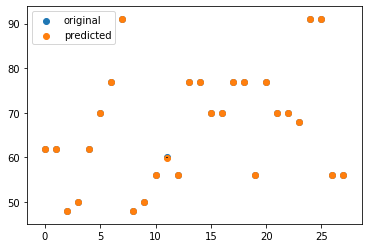

In [8]:
#plotting the ground truth values vs predicted values for XgB
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, label="original")
plt.scatter(x_ax, y_pred, label="predicted")
plt.vlines(x_ax, ymin=y_test, ymax=y_pred, colors='k')
plt.legend()
plt.show()

In [11]:
# 5 fold cross-validation for Multilayer Perceptron
ns=5
groups=flag.genotype
cv =GroupKFold(n_splits=ns)
rmse=0
R2=0
e=[]
for train_index, test_index in cv.split(X,y,groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model=MLPRegressor(hidden_layer_sizes=30, solver='sgd',momentum=0, learning_rate='constant', 
                       activation= 'tanh',
                       learning_rate_init=0.01, verbose=True, max_iter=3000, warm_start=True).fit(X_train, y_train)
    print(model.score(X_train,y_train))
    y_pred=model.predict(X_test)
    predictions=[round(value) for value in y_pred]
    rmse=rmse+math.sqrt(mean_squared_error(y_test, predictions))
    e.append(math.sqrt(mean_squared_error(y_test, predictions)))
    
std= (statistics.stdev(e))

print('Root Mean square error for 5-fold CV MLP:',rmse/ns, '+-', std)



Iteration 1, loss = 2161.33055051
Iteration 2, loss = 1761.91723747
Iteration 3, loss = 961.84649554
Iteration 4, loss = 512.49511105
Iteration 5, loss = 284.43631117
Iteration 6, loss = 173.70048436
Iteration 7, loss = 120.55634824
Iteration 8, loss = 95.13316654
Iteration 9, loss = 82.97741694
Iteration 10, loss = 77.15686997
Iteration 11, loss = 74.35684593
Iteration 12, loss = 72.99429326
Iteration 13, loss = 72.31333867
Iteration 14, loss = 71.95273278
Iteration 15, loss = 71.73920386
Iteration 16, loss = 71.58871859
Iteration 17, loss = 71.45917084
Iteration 18, loss = 71.32744213
Iteration 19, loss = 71.17774379
Iteration 20, loss = 70.99455833
Iteration 21, loss = 70.75576181
Iteration 22, loss = 70.41974196
Iteration 23, loss = 69.88693436
Iteration 24, loss = 68.84014652
Iteration 25, loss = 66.00250560
Iteration 26, loss = 62.49437874
Iteration 27, loss = 62.96419092
Iteration 28, loss = 56.28858773
Iteration 29, loss = 54.30783484
Iteration 30, loss = 47.73396834
Iteration 

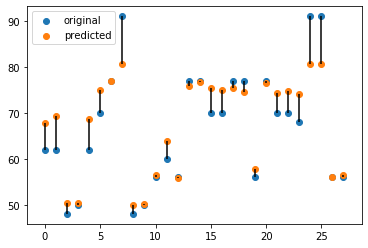

In [10]:
#plotting the ground truth values vs predicted values for MLP
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, label="original")
plt.scatter(x_ax, y_pred, label="predicted")
plt.vlines(x_ax, ymin=y_test, ymax=y_pred, colors='k')
plt.legend()
plt.show()